# SALES PREDICTION USING ARIMA AND PROPHET FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [7]:
#!pip install statsmodels
#!pip install pmdarima

In [160]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from matplotlib.gridspec import GridSpec
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)
from viz_utils import *

import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX, AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')

In [3]:
def stat_test(series):
    stat_test=adfuller(series)
    test_result = pd.Series(stat_test[0:4], index = ['Test statistics', 'p-value', 'Lags Used', 'Number of used observations'])
    print(test_result)

# 💾 CHECK OUT THE DATA

IMPORTANDO OS ARQUIVOS DO BUCKET DA AWS S3

In [4]:
orders = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_orders_dataset.csv"
customer = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_customers_dataset.csv"
item = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_items_dataset.csv"
products = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_products_dataset.csv"
sellers = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_sellers_dataset.csv"
order_pay = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_payments_dataset.csv"
category ="https://stack-labs-landing.s3.amazonaws.com/datasets/product_category_name_translation.csv"

In [5]:
df_orders = pd.read_csv(orders)
df_customers = pd.read_csv(customer)
df_item = pd.read_csv(item)
df_products = pd.read_csv(products)
df_sellers = pd.read_csv(sellers)
df_order_pay = pd.read_csv(order_pay)
df_category = pd.read_csv(category)

**MERGE DF_ORDERS WITH DF_CUSTOMERS**

In [6]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

**ALL IN ONE**

In [7]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

print(df_train.shape)

(119143, 39)


In [9]:
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,8/15/2017 18:29,8/15/2017 20:05,8/17/2017 15:28,8/18/2017 14:44,8/28/2017 0:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,8/2/2017 18:24,8/2/2017 18:43,8/4/2017 17:35,8/7/2017 18:30,8/15/2017 0:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP


**CONVERT DATE COLUMNS TO TIMESTAMP**

In [10]:
# Changing the datetime features to the correct format
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
                  
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
#df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Extracting attributes for purchase date - Year and Week
df_orders['order_purchase_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.week)
df_orders['order_purchase_year_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%U'))


# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))


# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_year_month,order_purchase_date,order_purchase_week,order_purchase_year_week,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2017-10,2017-10-02,40,2017-40,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,2018-07,2018-07-24,30,2018-29,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,2018-08,2018-08-08,32,2018-31,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,2017-12-02 00:28:00,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,2017-11,2017-11-18,46,2017-46,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2018-02-16 18:17:00,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,2018-02,2018-02-13,7,2018-06,13,1,Tue,21,Night


**CLEAN DATA**

In [11]:
#Counting number of empty rows in the df_orders
df_orders.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
order_id                            0
order_purchase_month                0
order_purchase_hour                 0
order_purchase_dayofweek_name       0
order_purchase_dayofweek            0
order_purchase_day                  0
order_purchase_year_week            0
order_purchase_week                 0
order_purchase_date                 0
order_purchase_year_month           0
customer_state                      0
order_purchase_year                 0
customer_id                         0
customer_city                       0
customer_zip_code_prefix            0
customer_unique_id                  0
order_estimated_delivery_date       0
order_purchase_timestamp            0
order_status                        0
order_purchase_time_day             0
dtype: int64

In [12]:
#Counting number of empty rows in the df_train
df_train.isnull().sum().sort_values(ascending = False)

review_comment_title             105154
review_comment_message            68898
order_delivered_customer_date      3421
product_name_lenght                2542
product_category_name              2542
product_photos_qty                 2542
product_description_lenght         2542
order_delivered_carrier_date       2086
review_answer_timestamp             997
review_creation_date                997
review_id                           997
review_score                        997
product_width_cm                    853
product_length_cm                   853
product_weight_g                    853
product_height_cm                   853
freight_value                       833
seller_state                        833
price                               833
shipping_limit_date                 833
seller_id                           833
order_item_id                       833
seller_zip_code_prefix              833
seller_city                         833
product_id                          833


In [14]:
# Dropping the review_comment_title column, as all values are null
df_train.drop(['review_comment_title'], axis=1, inplace=True)

**Drop nan values**                                                  PROBLEMA NA CELULA ABAIXO?

df_train_0 = df_train.shape[0]
#Remove missing values with dropna
df_train= df_train.dropna()
df_train_1 = df_train.shape[0]
print(f'{round(((df_train_0-df_train_1)/df_train_1)*100,2)}% nan values points were eliminated')

In [15]:
df_orders_0 = df_orders.shape[0]
#Remove missing values with dropna
df_orders= df_orders.dropna()
df_orders_1 = df_orders.shape[0]
print(f'{round(((df_orders_0-df_orders_1)/df_orders_1)*100,2)}% nan values points were eliminated')

0.0% nan values points were eliminated


In [ ]:
df_orders['']

Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?

# **EXPLORATORY DATA ANALYSIS**

# **Visualization E-commerce Price Overtime**

# Price Distribution

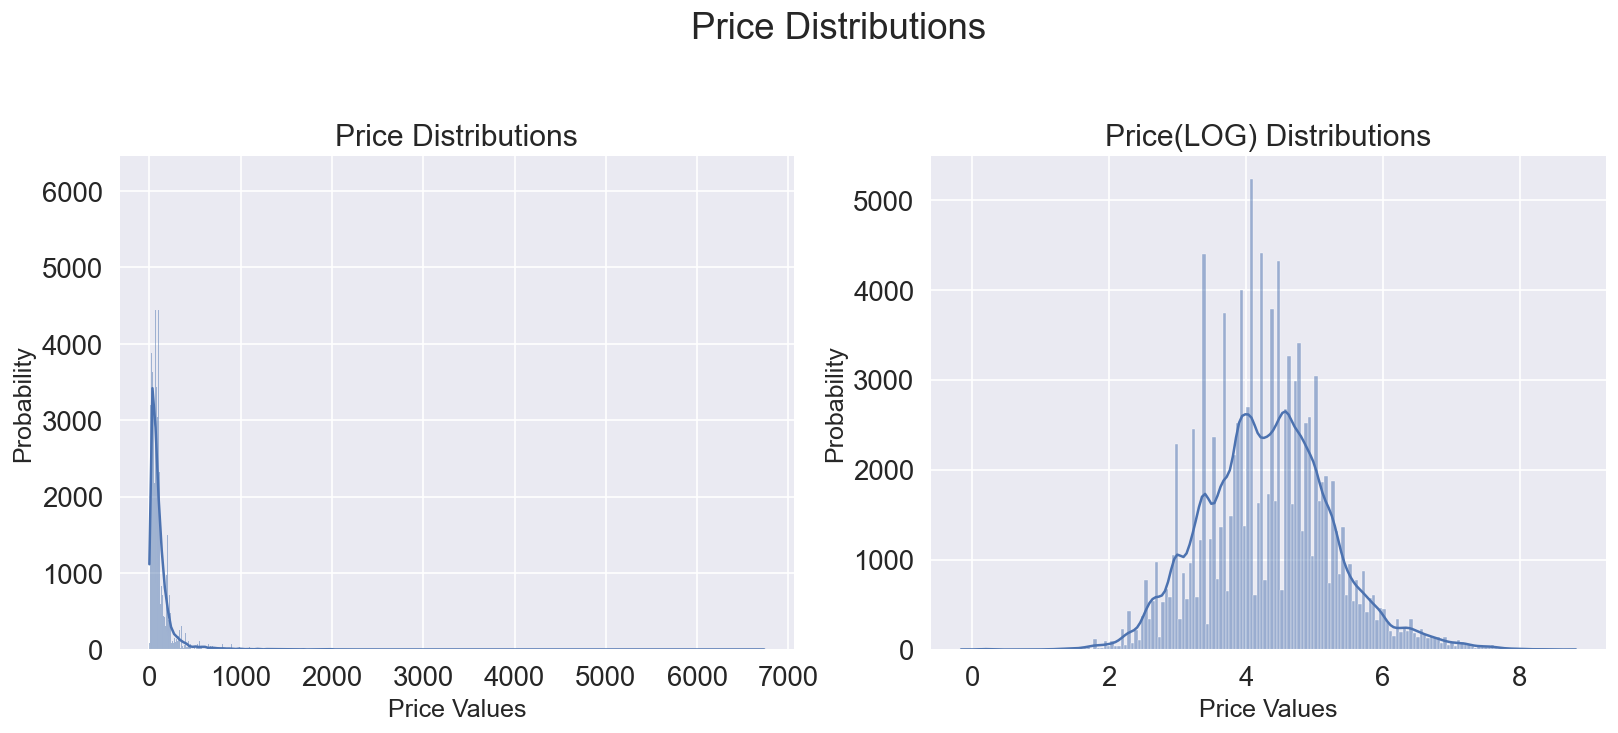

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


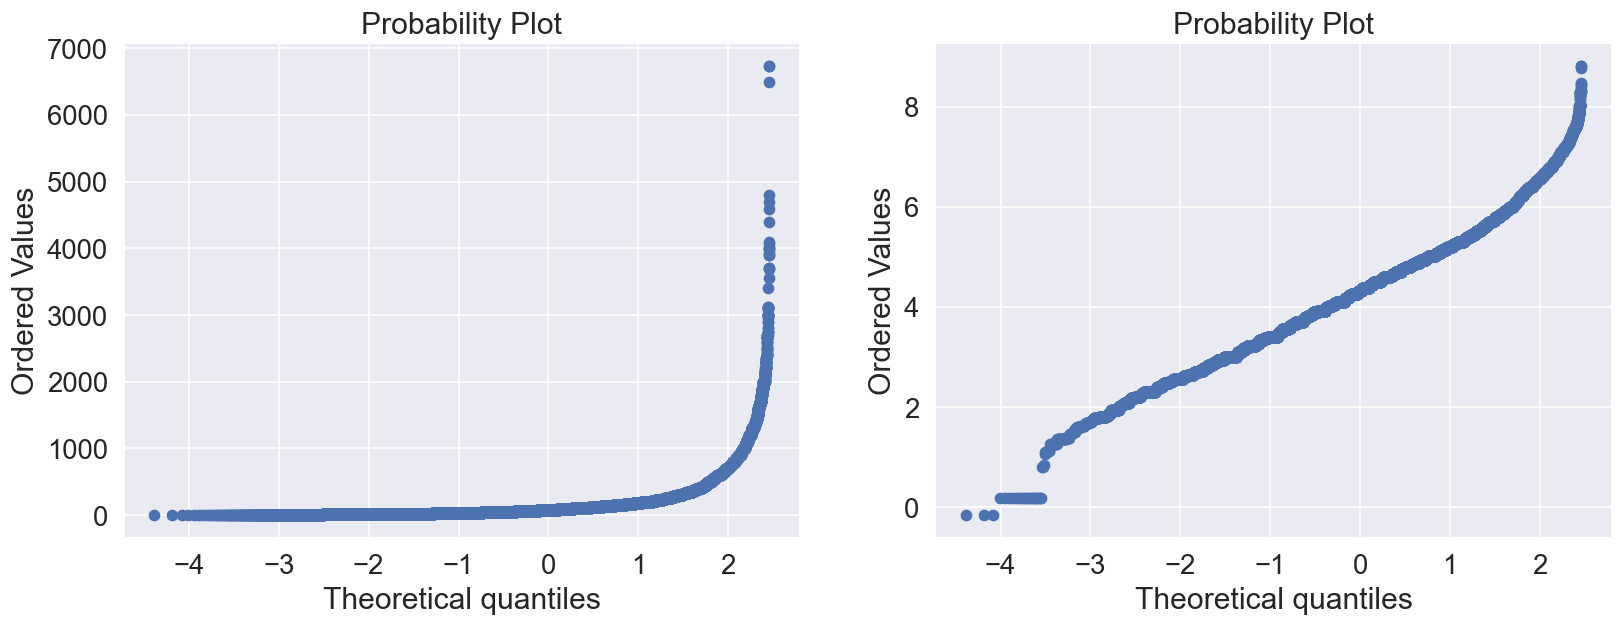

In [72]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);

plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

Price Distribution: Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

Price Log Distribution: Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

Probability Plot - Price Distribution: Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

Probability Plot - Price Log Distribution: Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

# VISUALIZATION E-COMMERCE DATAS OVERTIME

# **Evolution of E-Commerce Overtime - Amount of orders**

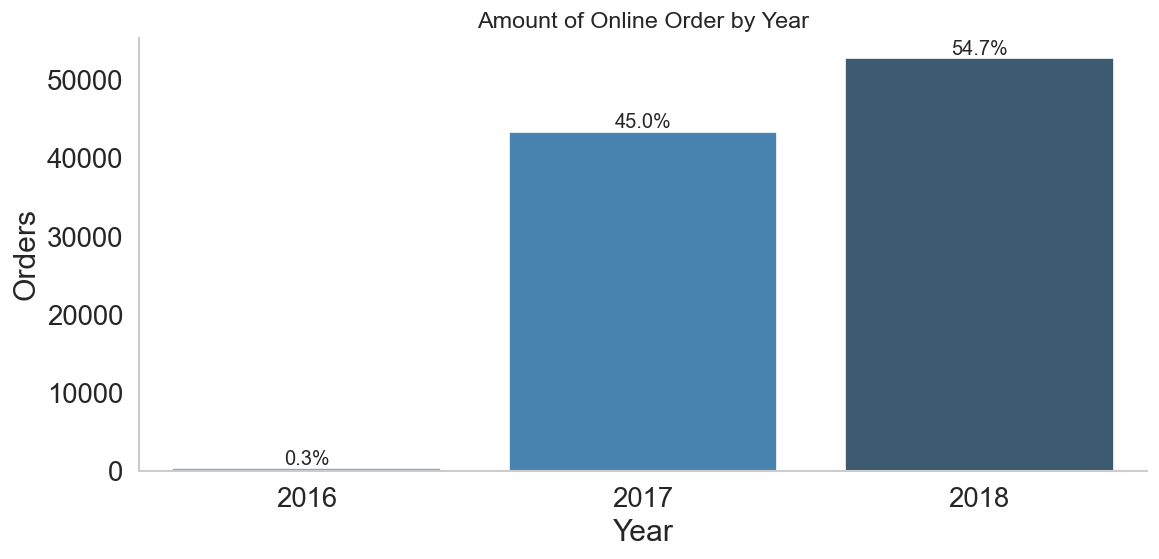

In [75]:
# Preparing the chart
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year', data=df_orders, palette='Blues_d')
format_spines(ax, right_border=False)

# Showing frequency
ncount = len(df_orders)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', size=12)

ax.set_title('Amount of Online Order by Year', size=14)
ax.set_ylabel('Orders')
ax.set_xlabel('Year')

plt.tight_layout()
plt.show()

The number of orders in 2016 was insignificant, only 0,3% of the total.

# **Evolution of E-Commerce Overtime - Total Sales per day**

In [16]:
df_sale = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_sale['order_purchase_timestamp'] = pd.to_datetime(df_sale['order_purchase_timestamp'])
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88789 entries, 0 to 88788
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  88789 non-null  datetime64[ns]
 1   price                     88789 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 MB


In [199]:
df_sale

,order_purchase_timestamp,price
88086,2016-09-04 21:15:00,72.89
88220,2016-09-05 00:15:00,59.50
85465,2016-09-13 15:24:00,0.00
85808,2016-09-15 12:16:00,134.97
8778,2016-10-02 22:07:00,100.00
...,...,...
87867,2018-09-29 09:13:00,0.00
7245,2018-10-01 15:30:00,0.00
10365,2018-10-03 18:55:00,0.00
8280,2018-10-16 20:16:00,0.00


In [203]:
# COMECEI A PARTIR DAQUI
# CRIEI 3 NOVOS DATAFRAMES. O DF CHAMADO PREVISAO FOI PREENCHIDO O VALOR NULLO COM A MEDIA, NO DF PREVISAO2 RETIREI OS 2 ULTIMOS MESES DE 2018 (09 E 10)
# E NO DF PREVISAO3 TAMBEM PREENCHI O VALOR DO MES 2016-12-01 COM A MEDIA.

In [18]:
df_sale['price'].min(), df_sale['price'].max()

(0.0, 13440.0)

In [19]:
df_sale = df_sale.sort_values('order_purchase_timestamp')

In [70]:
df_sale.isnull().sum()

order_purchase_timestamp    0
price                       0
dtype: int64

In [129]:
df_previsao = df_sale.set_index('order_purchase_timestamp')

In [130]:
df_previsao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88789 entries, 2016-09-04 21:15:00 to 2018-10-17 17:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   88789 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [134]:
previsao = df_previsao['price'].resample('MS').mean()
previsao.fillna(df_previsao['price'].mean(), inplace=True)


In [202]:
(previsao['2016':])

order_purchase_timestamp
2016-09-01     66.840000
2016-10-01    164.208746
2016-11-01    160.759775
2016-12-01     10.900000
2017-01-01    171.365858
2017-02-01    153.493767
2017-03-01    156.431214
2017-04-01    171.065516
2017-05-01    159.891365
2017-06-01    152.441598
2017-07-01    144.718857
2017-08-01    151.582536
2017-09-01    169.482003
2017-10-01    164.069000
2017-11-01    172.566585
2017-12-01    151.979179
2018-01-01    156.070597
2018-02-01    151.897591
2018-03-01    161.707189
2018-04-01    166.513496
2018-05-01    172.059217
2018-06-01    162.800184
2018-07-01    166.320190
2018-08-01    155.899827
2018-09-01      9.062500
2018-10-01      0.000000
Freq: MS, Name: price, dtype: float64

In [113]:
previsao2 = previsao.drop(labels=['2018-09-01', '2018-10-01'])

In [201]:
previsao2

order_purchase_timestamp
2016-09-01     66.840000
2016-10-01    164.208746
2016-11-01    160.759775
2016-12-01     10.900000
2017-01-01    171.365858
2017-02-01    153.493767
2017-03-01    156.431214
2017-04-01    171.065516
2017-05-01    159.891365
2017-06-01    152.441598
2017-07-01    144.718857
2017-08-01    151.582536
2017-09-01    169.482003
2017-10-01    164.069000
2017-11-01    172.566585
2017-12-01    151.979179
2018-01-01    156.070597
2018-02-01    151.897591
2018-03-01    161.707189
2018-04-01    166.513496
2018-05-01    172.059217
2018-06-01    162.800184
2018-07-01    166.320190
2018-08-01    155.899827
Freq: MS, Name: price, dtype: float64

In [140]:
previsao3 = previsao2.replace(10.900000, 160.759775)

In [141]:
previsao3.head()

order_purchase_timestamp
2016-09-01     66.840000
2016-10-01    164.208746
2016-11-01    160.759775
2016-12-01    160.759775
2017-01-01    171.365858
Freq: MS, Name: price, dtype: float64

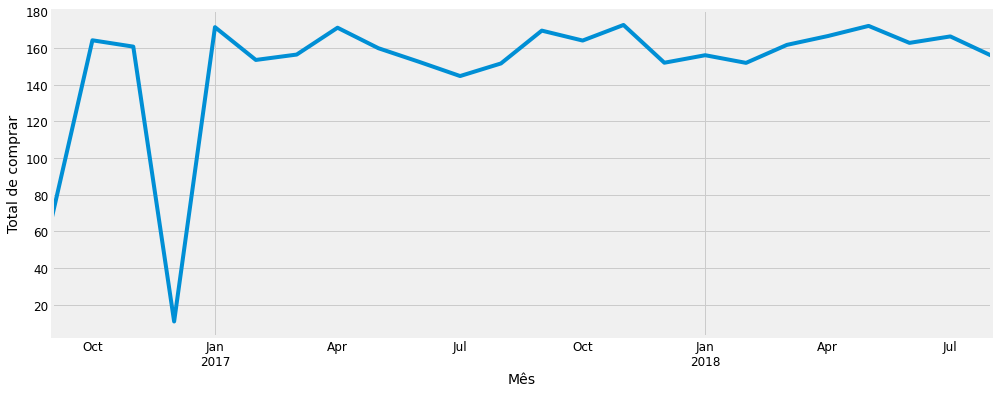

In [154]:
previsao2.plot(figsize=(15, 6))
plt.xlabel("Mês")
plt.ylabel("Total de comprar")
plt.show()

# OBSERVA-SE QUE NO MÊS 11 (NOVEMBRO) NÃO HÁ REGISTROS, SENDO ASSIM EXISTE UM GAP NA VISUALIZAÇÃO DAS VENDAS. AINDA TEMOS QUE TRABALHAR PARA ENTENDER O PORQUE DESSE GAP NOS DADOS.

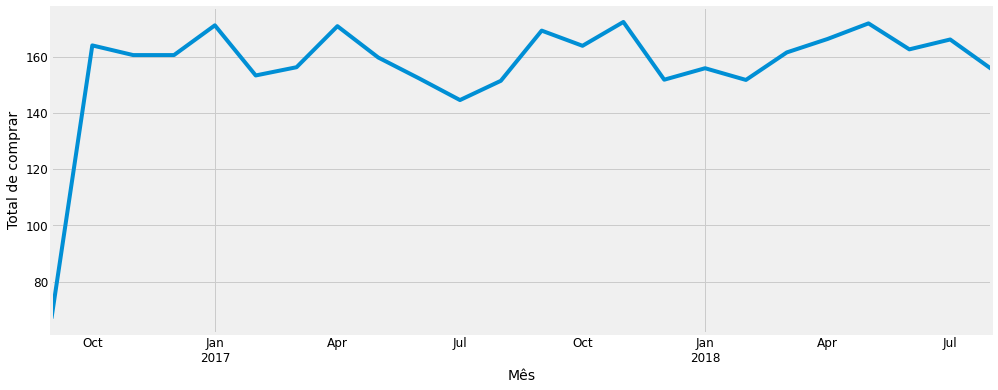

In [153]:
previsao3.plot(figsize=(15, 6))
plt.xlabel("Mês")
plt.ylabel("Total de comprar")
plt.show()

Nota-se uma continuação no número de vendas e uma pequena sazonalidade, como as vendas sendo um pouco mais baixas entre os meses de Janeiro e Março. 

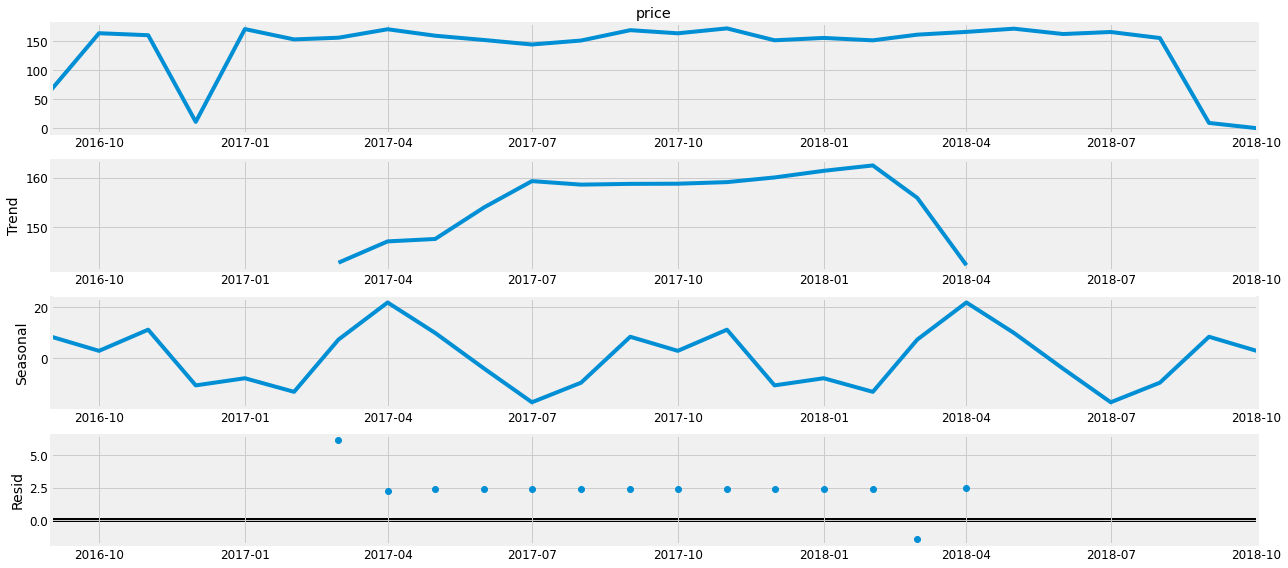

In [146]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(previsao, model='additive')
fig = decomposition.plot()
plt.show()

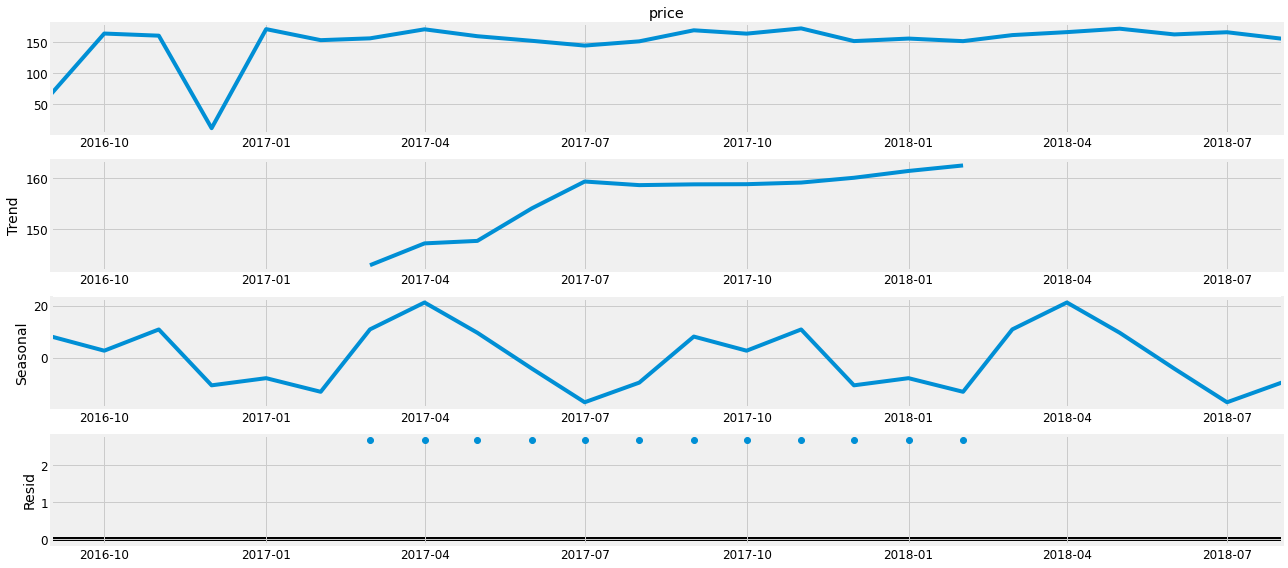

In [147]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(previsao2, model='additive')
fig = decomposition.plot()
plt.show()

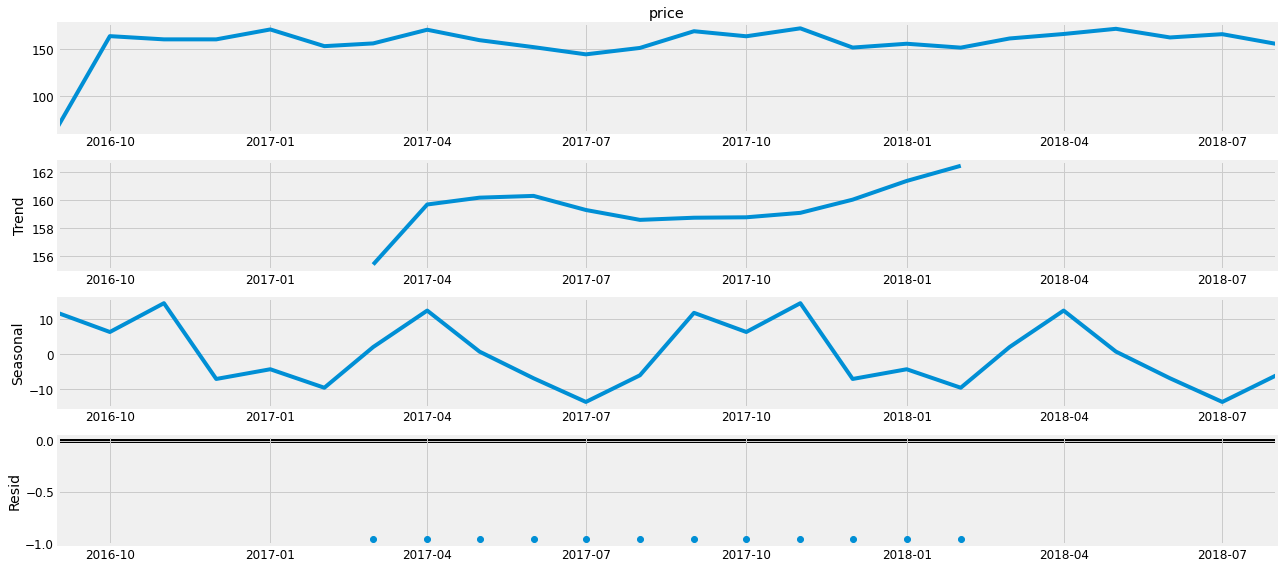

In [145]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(previsao3, model='additive')
fig = decomposition.plot()
plt.show()

In [178]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(previsao3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:313.1644596749934
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:302.4473376709597
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:118.7230644624061
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:120.71133223254539
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:276.18701683157906
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:278.1870167597666
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:120.70083447257373
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:122.70092425682701
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:286.2683304060061
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:276.3583636939516
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:120.68809324949967
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:122.77819466248783
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:266.5121091964158
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:267.93414753753933
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:122.77767087679797
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:124.79825598051315
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:210.54674931332187
SARIMAX(0, 1, 0)x(0, 

In [181]:
# A saída acima sugere que o SARIMAX (0,1,0) x (0, 1, 0, 12) produz o menor valor de AIC de 110.35220052104589. Portanto, devemos considerar sso como melhor opção.

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   24
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -54.176
Date:                            Wed, 12 Jan 2022   AIC                            110.352
Time:                                    16:09:32   BIC                            110.750
Sample:                                09-01-2016   HQIC                           110.101
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1110.2120    248.418      4.469      0.000     623.322    1597.102
Ljung-Box (L1) (Q):                

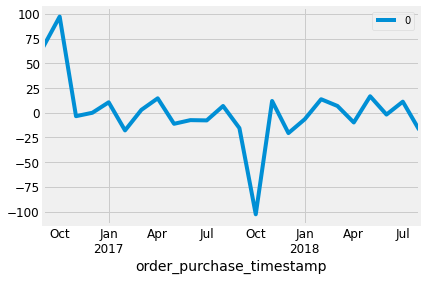

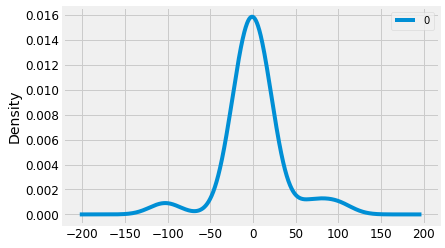

                0
count   24.000000
mean     1.571615
std     34.450138
min   -102.781749
25%    -10.164534
50%     -0.904633
75%     11.418699
max     97.368746


In [182]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(previsao3, order=(0,1,0), seasonal_order=(0,1,0,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

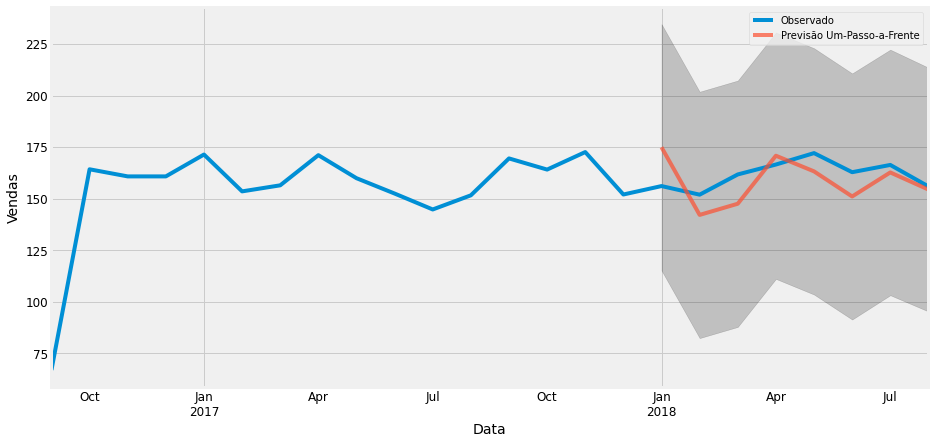

In [208]:
# VALIDANDO AS PREVISOES

pred_previsao = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_previsao.conf_int()
ax = previsao3['2016':].plot(label='Observado')
pred_previsao.predicted_mean.plot(ax=ax, label='Previsão Um-Passo-a-Frente', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Vendas')
plt.legend()
plt.show()

In [192]:
previsao_forecasted = pred_previsao.predicted_mean
previsao3_truth = previsao3['2018-01-01':]
mse = ((previsao_forecasted - previsao3_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 112.97


In [193]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 10.63


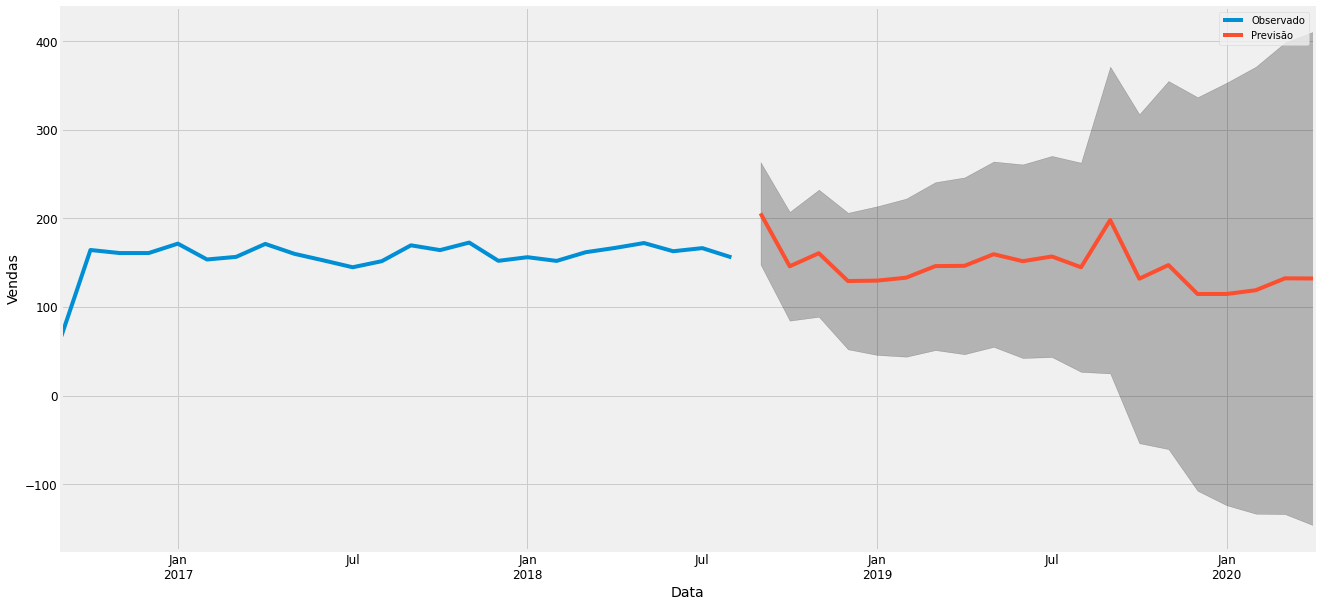

In [212]:
# PRDUZINDO E VISUALIZANDO AS PREVISOES

pred_uc = results.get_forecast(steps=20)
pred_ci2 = pred_uc.conf_int()
ax = previsao3.plot(label='Observado', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Vendas')
plt.legend()
plt.show()

In [158]:
# FIZ ALGO NOVO ATE AQUI

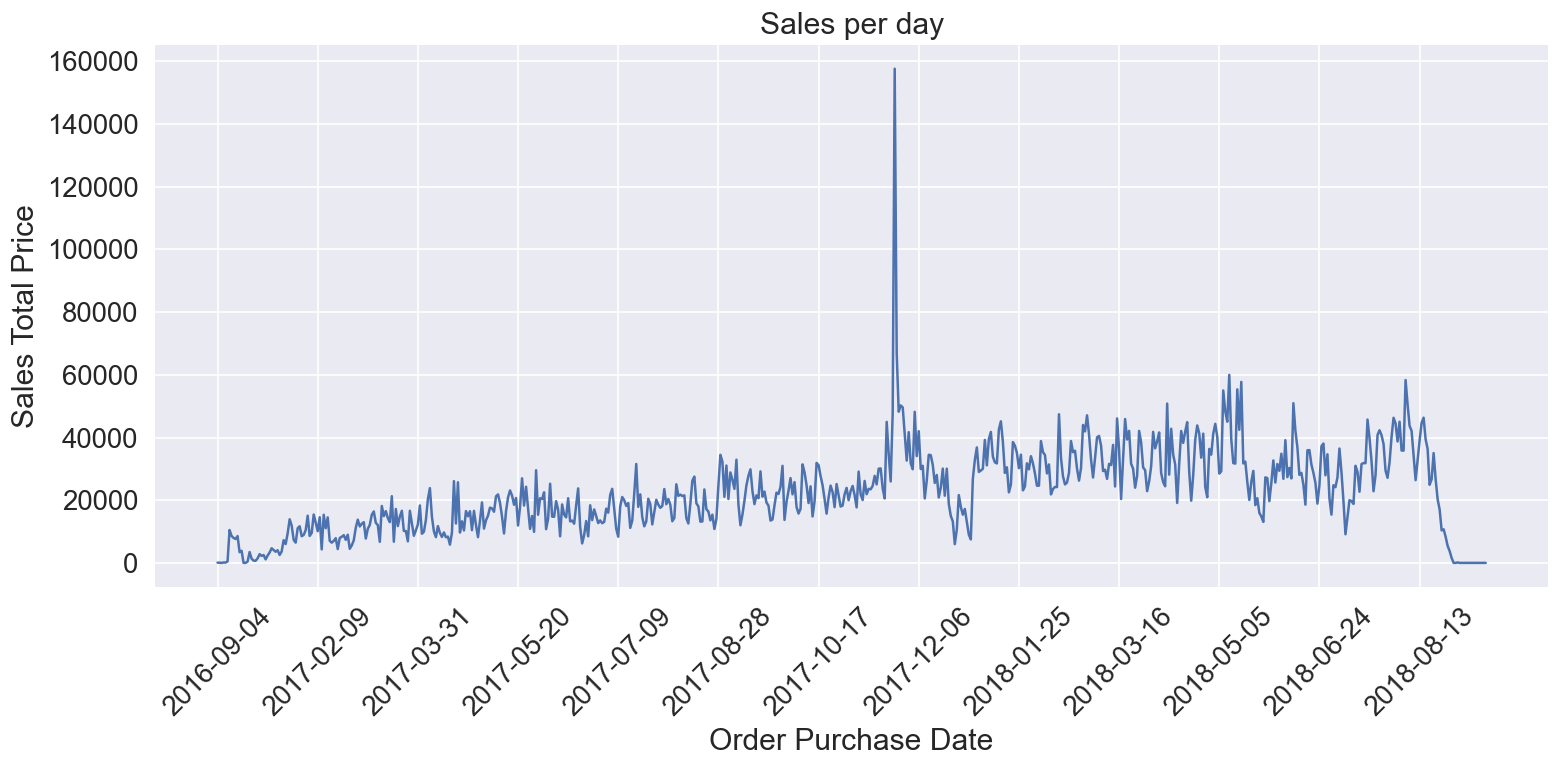

In [78]:
#Sizing the table
plt.subplots(figsize=(15, 6))

# creating a purchase day feature
df_sale['sales_daily'] = df_sale['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')

# creating an aggregation
total_sales_daily = df_sale.groupby('sales_daily', as_index=False).price.sum()
ax = sns.lineplot(x="sales_daily", y="price", data=total_sales_daily)
ax.set_title('Sales per day')
ax.set_ylabel('Sales Total Price')
ax.set_xlabel('Order Purchase Date')
ax.set_xticks(ax.get_xticks()[::50])
plt.xticks(rotation=45);

In [79]:
total_sales_daily['sales_daily']=pd.to_datetime(total_sales_daily['sales_daily'])
total_sales_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sales_daily  634 non-null    datetime64[ns]
 1   price        634 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.0 KB


# **Evolution of E-Commerce Overtime - Total Sales per week**

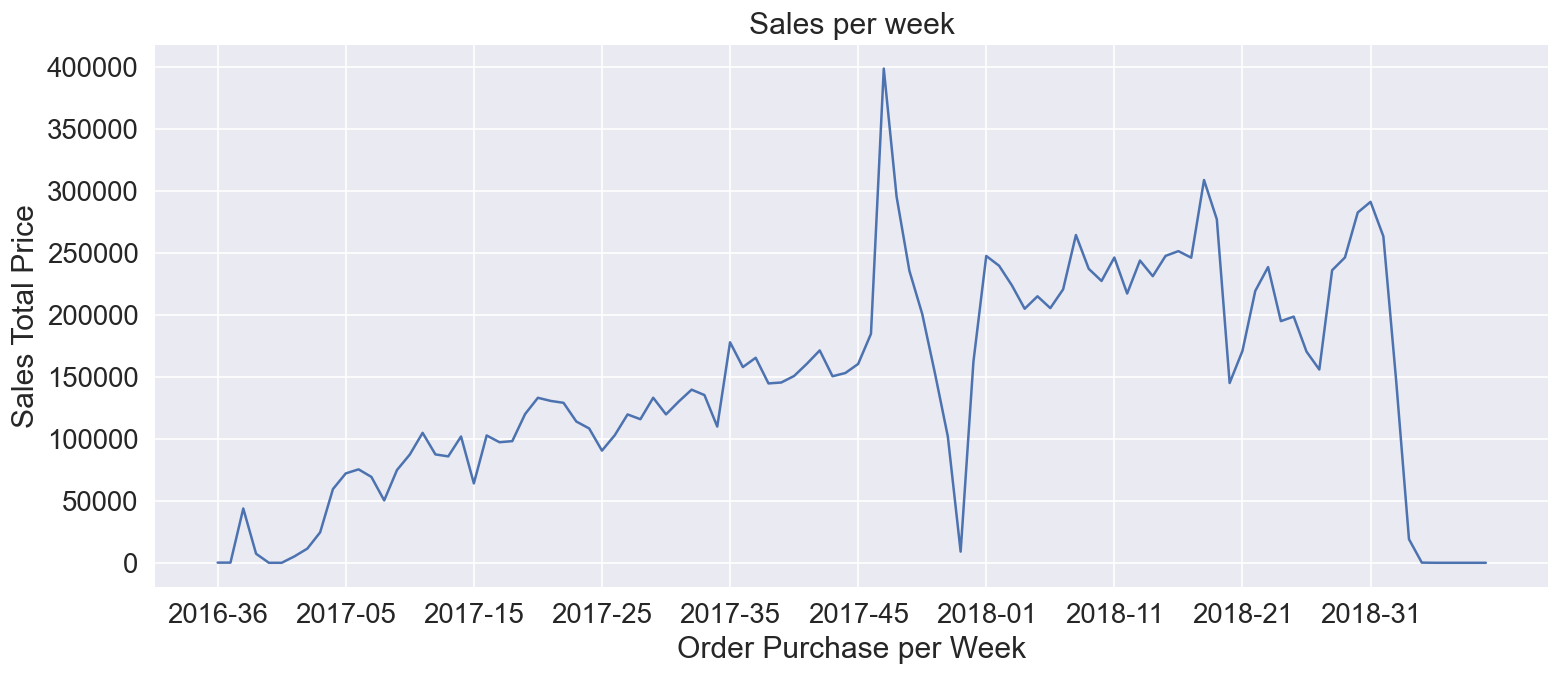

In [80]:
#Sizing the table
plt.subplots(figsize=(15, 6))

# creating a weekly sales total price feature
df_sale['sales_weekly'] = df_sale['order_purchase_timestamp'].dt.strftime('%Y-%U')

# creating an aggregation
total_sales_weekly = df_sale.groupby('sales_weekly', as_index=False).price.sum()
ax = sns.lineplot(x="sales_weekly", y="price", data=total_sales_weekly)
ax.set_title('Sales per week')
ax.set_ylabel('Sales Total Price')
ax.set_xlabel('Order Purchase per Week')
ax.set_xticks(ax.get_xticks()[::10]);

# **Evolution of E-Commerce Overtime - Total Sales per month**

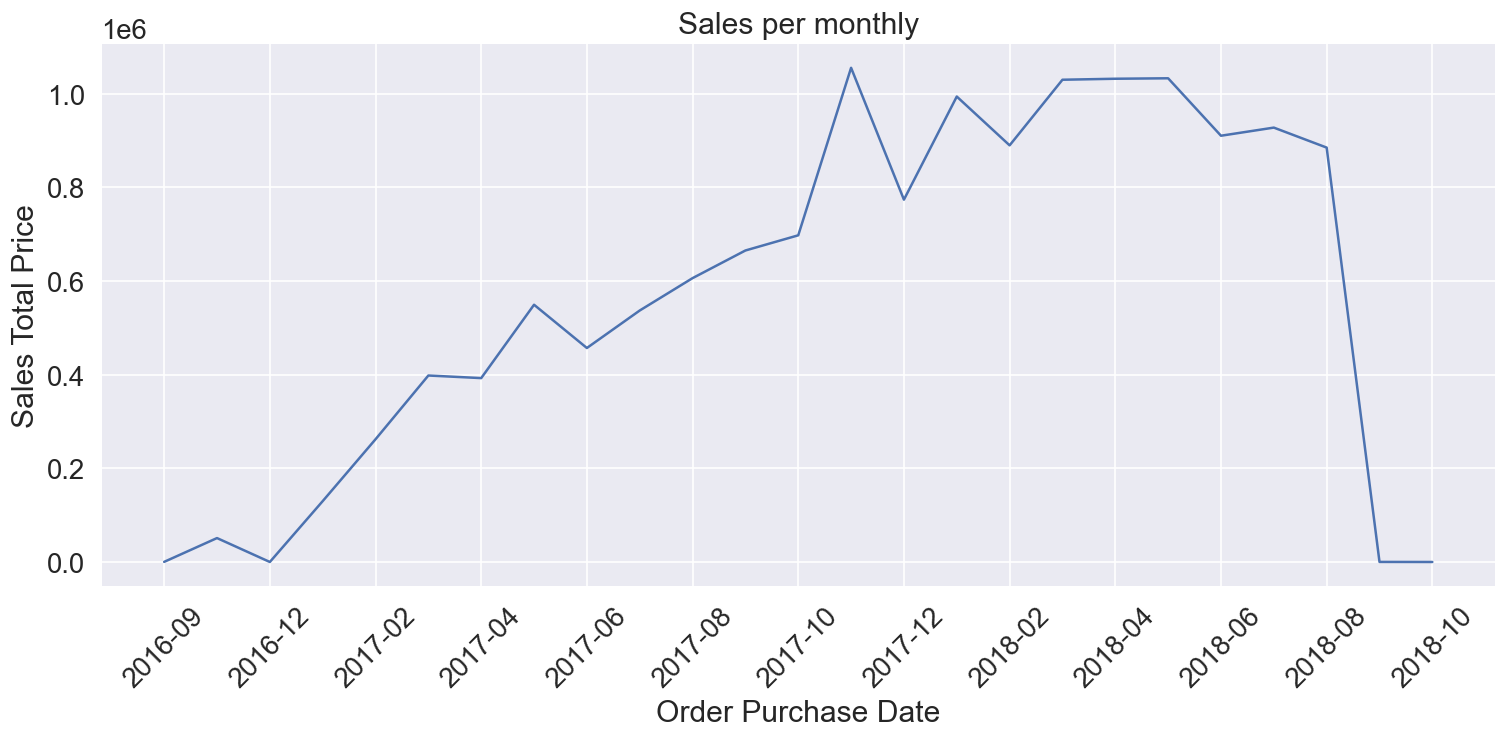

In [81]:
#Sizing the table
plt.subplots(figsize=(15, 6))

# creating a weekly sales total price feature
#df_train['sales_monthly'] = pd.to_datetime(df_train.order_purchase_timestamp, format='%Y-%m')
df_sale['sales_monthly'] = df_sale['order_purchase_timestamp'].dt.strftime('%Y-%m')

# creating an aggregation
total_sales_weekly = df_sale.groupby('sales_monthly', as_index=False).price.sum()
ax = sns.lineplot(x="sales_monthly", y="price", data=total_sales_weekly)
ax.set_title('Sales per monthly')
ax.set_ylabel('Sales Total Price')
ax.set_xlabel('Order Purchase Date')
ax.set_xticks(ax.get_xticks()[::2])
plt.xticks(rotation=45);

# **Customer's State Distribution**

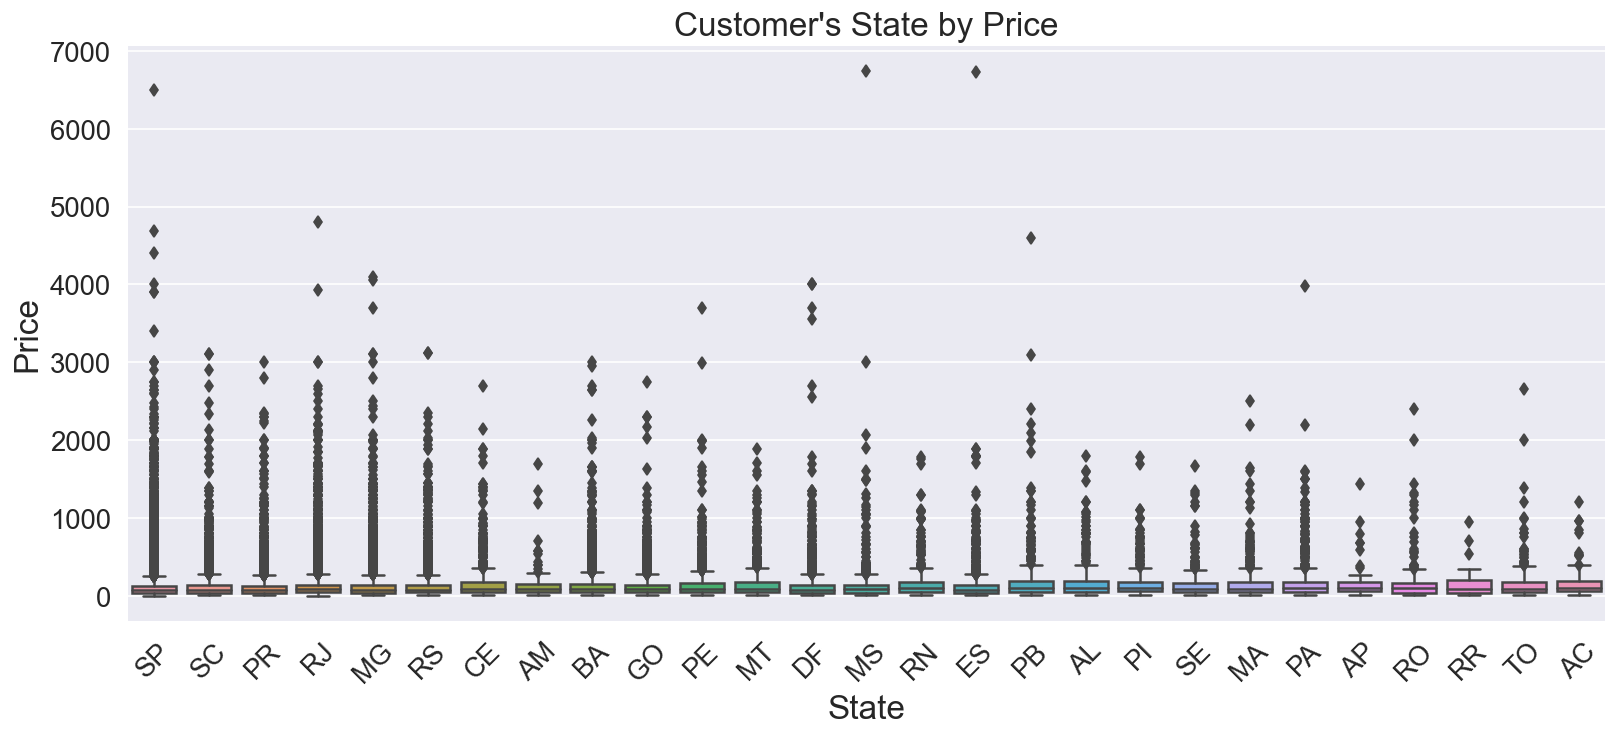

In [82]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

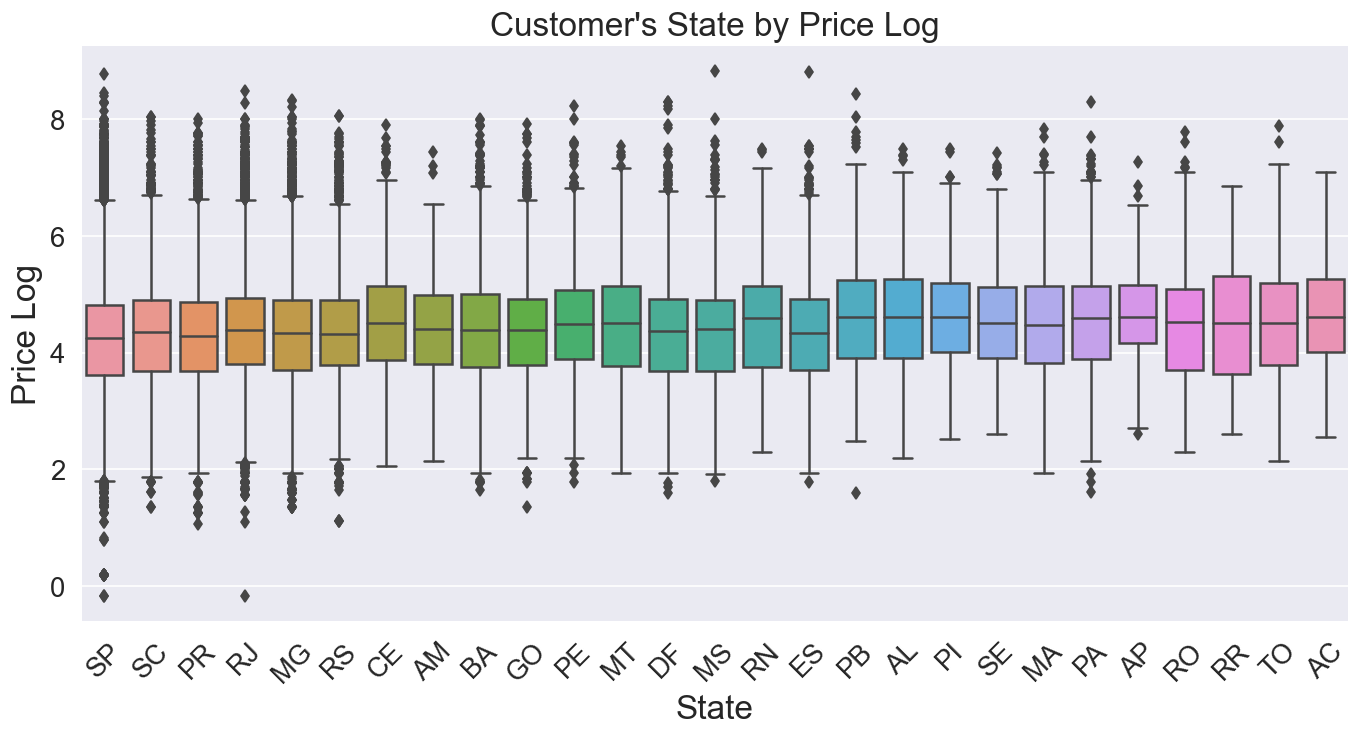

In [83]:
plt.figure(figsize=(30,14))
df_train['price_log'] = np.log(df_train['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

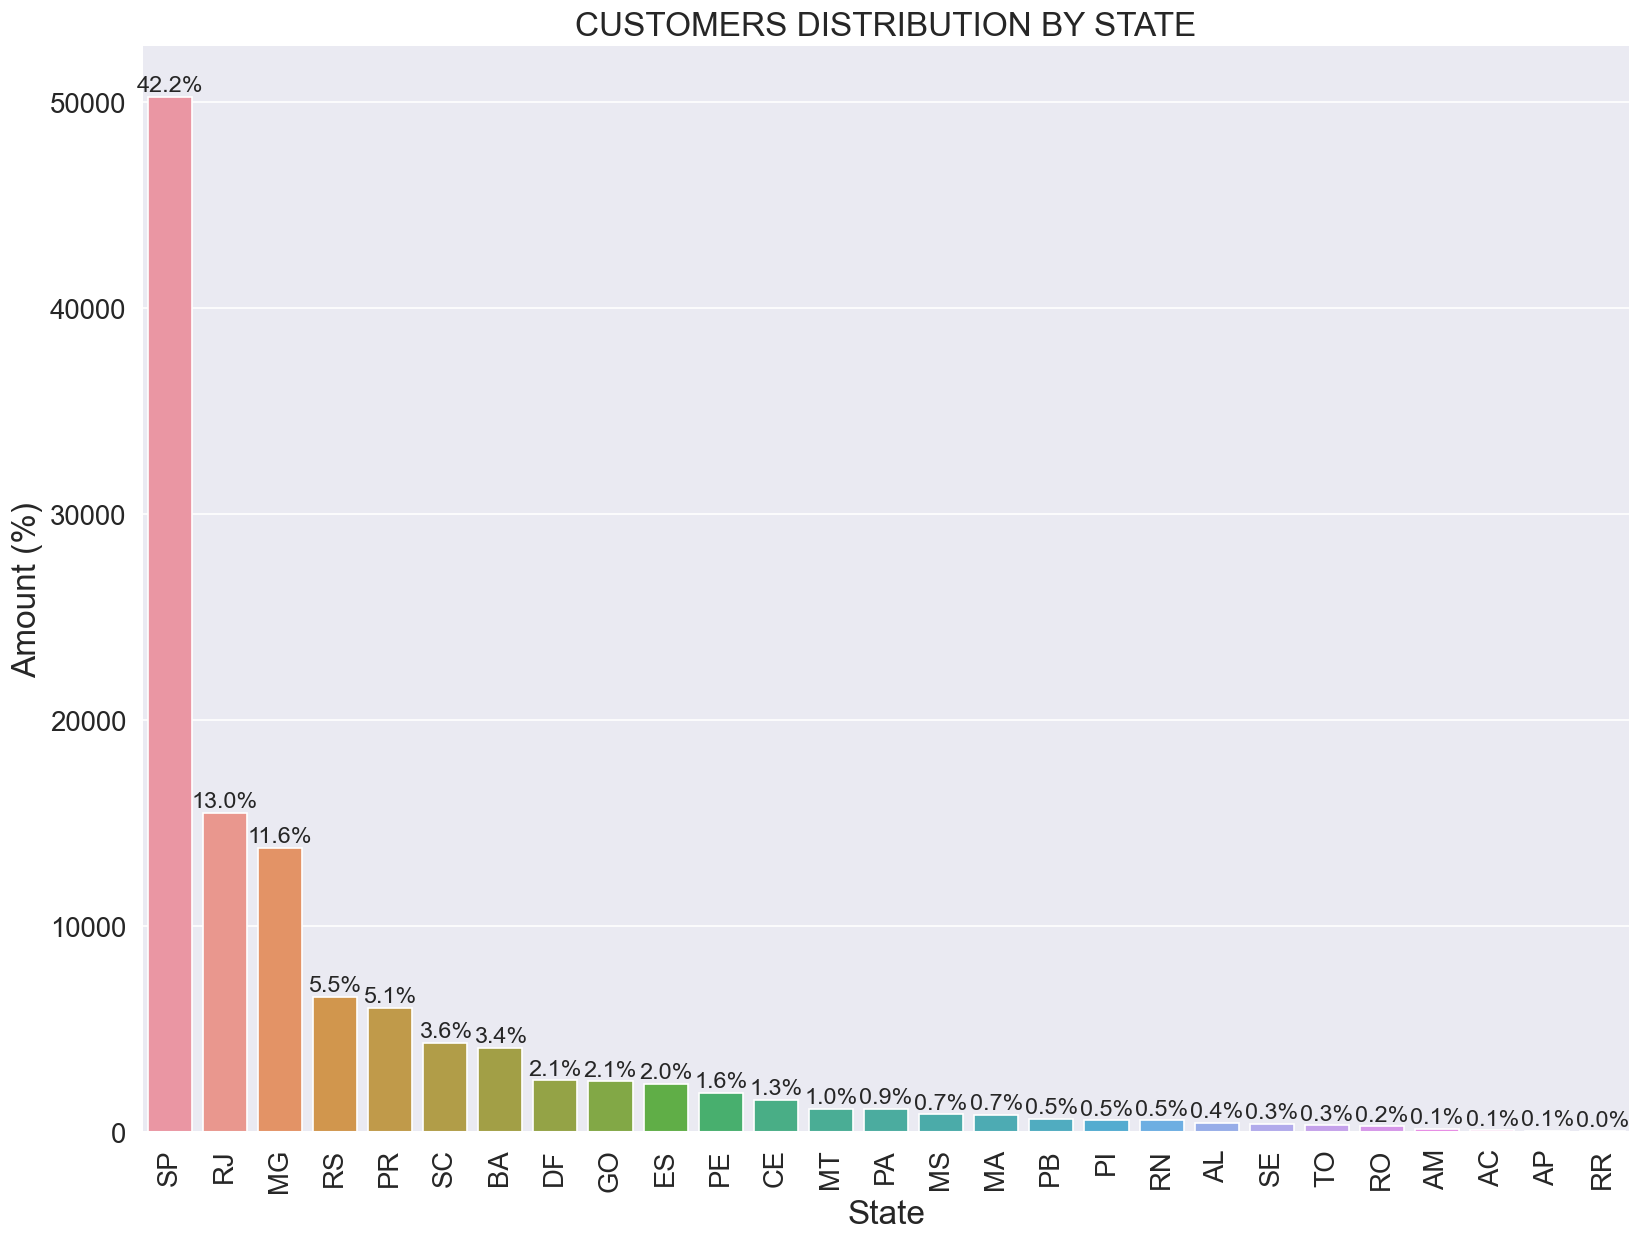

In [85]:
plt.figure(figsize=(16,12))

ax = sns.countplot(x='customer_state', data=df_train, orient='h', order=df_train['customer_state'].value_counts().index)
ax.set_title("CUSTOMERS DISTRIBUTION BY STATE", fontsize=20)
ax.set_xlabel("State", fontsize=20)
ax.set_ylabel("Amount (%)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14)
    

plt.show()

# **Visualization E-commerce Purchase Order Overtime**

# **Purchase order Distribution**

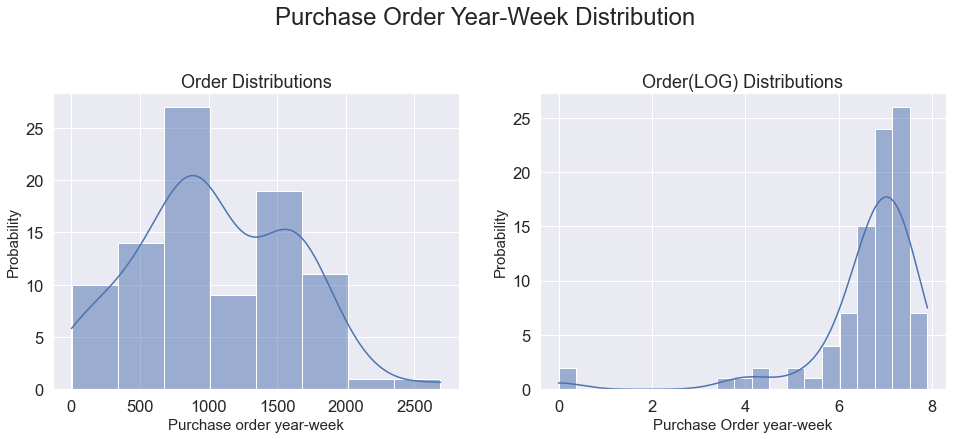

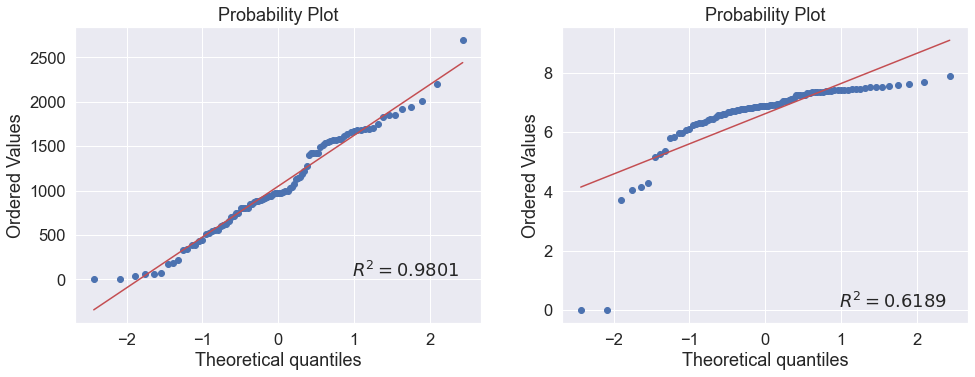

In [30]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Purchase Order Year-Week Distribution', fontsize=24)
plt.subplot(221)
g = sns.histplot(df_orders['order_purchase_year_week'].value_counts(), kde=True)
g.set_title("Order Distributions", fontsize=18)
g.set_xlabel("Purchase order year-week", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_orders['order_purchase_year_week'].value_counts()), kde=True)
g1.set_title("Order(LOG) Distributions", fontsize=18)
g1.set_xlabel("Purchase Order year-week", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.subplot(221)
res = stats.probplot(df_orders['order_purchase_year_week'].value_counts(), plot=plt, fit=True, rvalue=True);


plt.subplot(222)
res = stats.probplot(np.log(df_orders['order_purchase_year_week'].value_counts()), plot=plt, fit=True, rvalue=True);

plt.show()

**Purchase Order Distribution:**
Histogram of a sample from a  normal distribution – it looks fairly symmetric and bimodal.

**Price Log Distribution:**
Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

**Probability Plot - Price Distribution:**
Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

**Probability Plot - Price Log Distribution:**
Probability plot of a sample from a Right-skewed distribution – it looks fairly straight, at least when the few large and small values are ignored.

**Checking the minimum and maximum points of each dataframe date**

In [31]:
#number of orders per month of the year
df_orders_year_month=df_orders['order_purchase_year_month'].value_counts().sort_index()
#number of orders per year-week
df_orders_year_week=df_orders['order_purchase_year_week'].value_counts().sort_index()

In [32]:
df_train['order_purchase_timestamp'].min(), df_train['order_purchase_timestamp'].max()

('1/1/2018 10:24', '9/9/2017 9:54')

In [33]:
df_orders['order_purchase_timestamp'].min(), df_orders['order_purchase_timestamp'].max()

(Timestamp('2016-09-15 12:16:00'), Timestamp('2018-08-29 15:00:00'))

**Creating one dataframe to predict the total sale**

In [34]:
df_train = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])
print(df_train.shape)

(88789, 2)


In [35]:
#The second column (price) was renamed to sales.
#df_train.columns.values[1] = "sales"
#Let's go understand the data better
df_train.describe().round(2)

,price
count,88789.00
mean,160.76
std,263.75
min,0.00
25%,49.90
50%,98.00
75%,176.99
max,13440.00


With a standard deviation of 242.48 and an average of 144.36, we can conclude that the variable has a  large variation.

**Analyzing the outliers**

Text(0, 0.5, '')

<Figure size 1440x360 with 0 Axes>

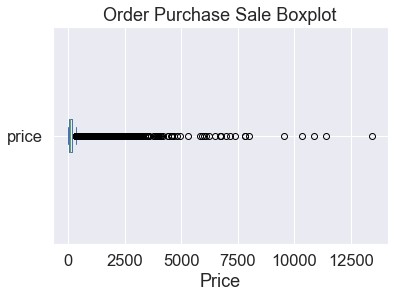

In [36]:
#Data Order Purchase Analysis
plt.figure(figsize=(20,5))
df_train.plot.box(title='Order Purchase Sale Boxplot', vert=0);
plt.xlabel('Price')
plt.ylabel('')

# **Order  Data Time Series**

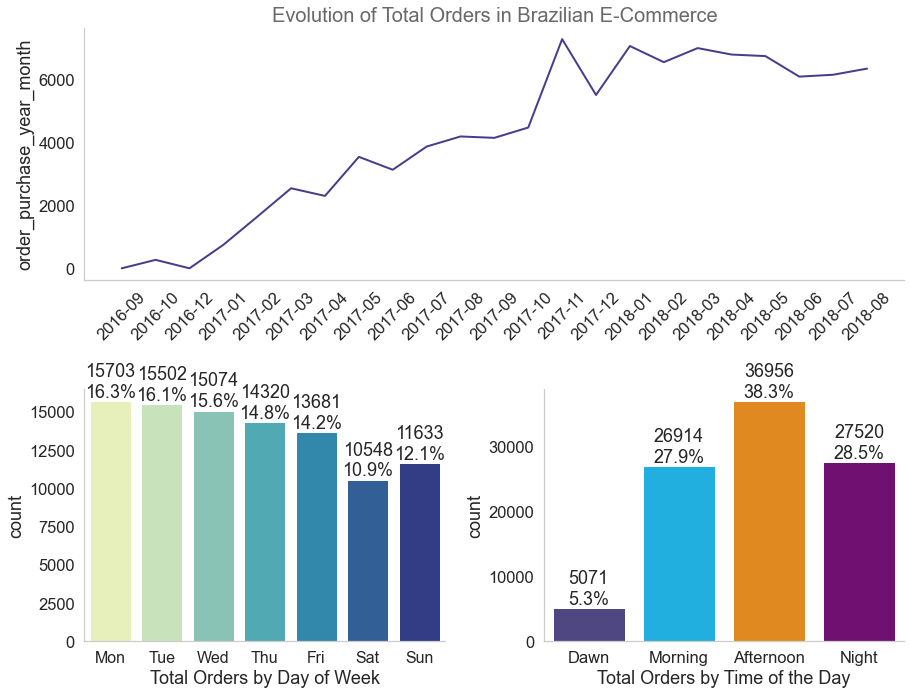

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)

ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=20, color='dimgrey')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label, fontsize=16)
ax2.set_xlabel('Total Orders by Day of Week')

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_xlabel('Total Orders by Time of the Day')


plt.tight_layout()
plt.show()

**Evolution of Total Orders in Brazilian E-Commerce per Year-Week**

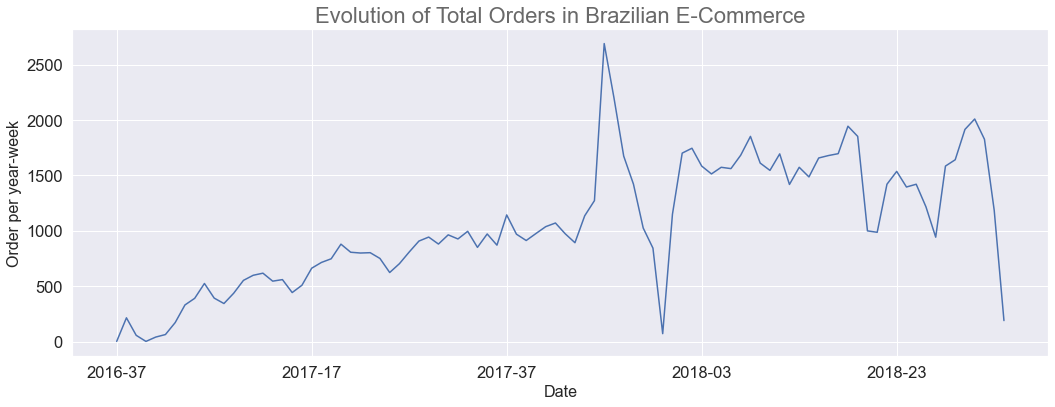

In [38]:
df_orders_year_week.plot(figsize=(15, 6))
plt.xlabel('Date', size=16)
plt.ylabel('Order per year-week', size=16)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=22, color='dimgrey')
plt.tight_layout()
plt.show()

In [39]:
#Determine rolling statistics for times series with year-month
df_orders_year_month_mean = df_orders_year_month.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_orders_year_month_std = df_orders_year_month.rolling(window=12).std()
print(df_orders_year_month_mean,df_orders_year_month_std)

2016-09            NaN
2016-10            NaN
2016-12            NaN
2017-01            NaN
2017-02            NaN
2017-03            NaN
2017-04            NaN
2017-05            NaN
2017-06            NaN
2017-07            NaN
2017-08            NaN
2017-09    2200.333333
2017-10    2573.416667
2017-11    3158.250000
2017-12    3617.583333
2018-01    4144.333333
2018-02    4553.916667
2018-03    4925.333333
2018-04    5299.916667
2018-05    5566.916667
2018-06    5813.666667
2018-07    6004.000000
2018-08    6183.833333
Name: order_purchase_year_month, dtype: float64 2016-09            NaN
2016-10            NaN
2016-12            NaN
2017-01            NaN
2017-02            NaN
2017-03            NaN
2017-04            NaN
2017-05            NaN
2017-06            NaN
2017-07            NaN
2017-08            NaN
2017-09    1629.185370
2017-10    1591.942750
2017-11    1923.403854
2017-12    1751.339252
2018-01    1760.352823
2018-02    1695.545472
2018-03    1703.859114
2018-04  

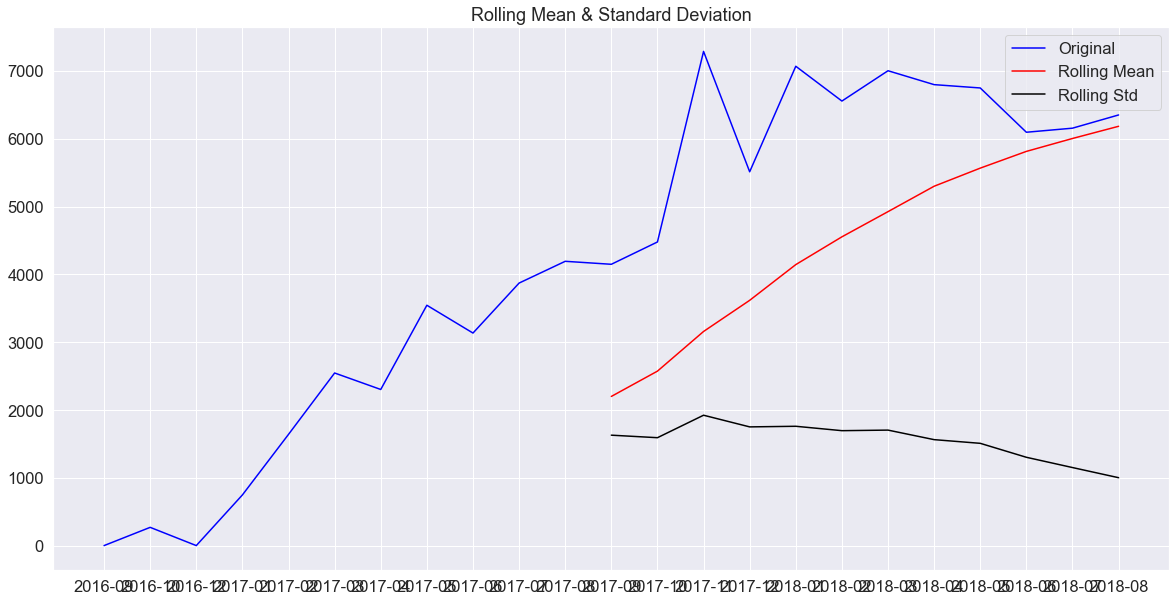

In [40]:
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot(df_orders_year_month, color='blue', label='Original')
df_orders_year_month_mean = plt.plot(df_orders_year_month_mean, color='red', label='Rolling Mean')
df_orders_year_month_std = plt.plot(df_orders_year_month_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# **CREATING AN SARIMA MODEL FOR TIME SERIES FORECASTING - TOTAL ORDER PER YEAR-MONTH**

**STATIONARITY TESTE**

A time series with constant mean and zero variance is considered to be stationary.

Time series should be made stationary using transformation techniques (log, moving average, etc.) before applying ARIMA models. ADF test is a great way and one of the most widely used techniques to confirm if the series is stationary or not.

In [41]:
# Test of stationarity.
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

from statsmodels.tsa.stattools import adfuller

result=adfuller(df_orders_year_month.dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-1.7895872416413952
p-valor:0.38564345586227744


**As p-value >0.05, the null hypothesis that the series is not stationary is not rejected..** Then, we need apply transformation techniques before applying ARIMA models.

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

# Dealing with non-stationary series - for order in year-month

In [42]:
# Log function
log_series_order = pd.Series(np.log(df_orders_year_month.values))
stat_test(log_series_order)

Test statistics               -5.848172e+00
p-value                        3.641844e-07
Lags Used                      9.000000e+00
Number of used observations    1.300000e+01
dtype: float64


In [43]:
# Differentiating
diff_series = pd.Series(df_orders_year_month.diff().values)
diff_series.dropna(inplace = True)
stat_test(diff_series)

Test statistics                 1.409117
p-value                         0.997155
Lags Used                       9.000000
Number of used observations    12.000000
dtype: float64


Clearly, the best option regarding this dataset is to apply log tansformation and predict with it.

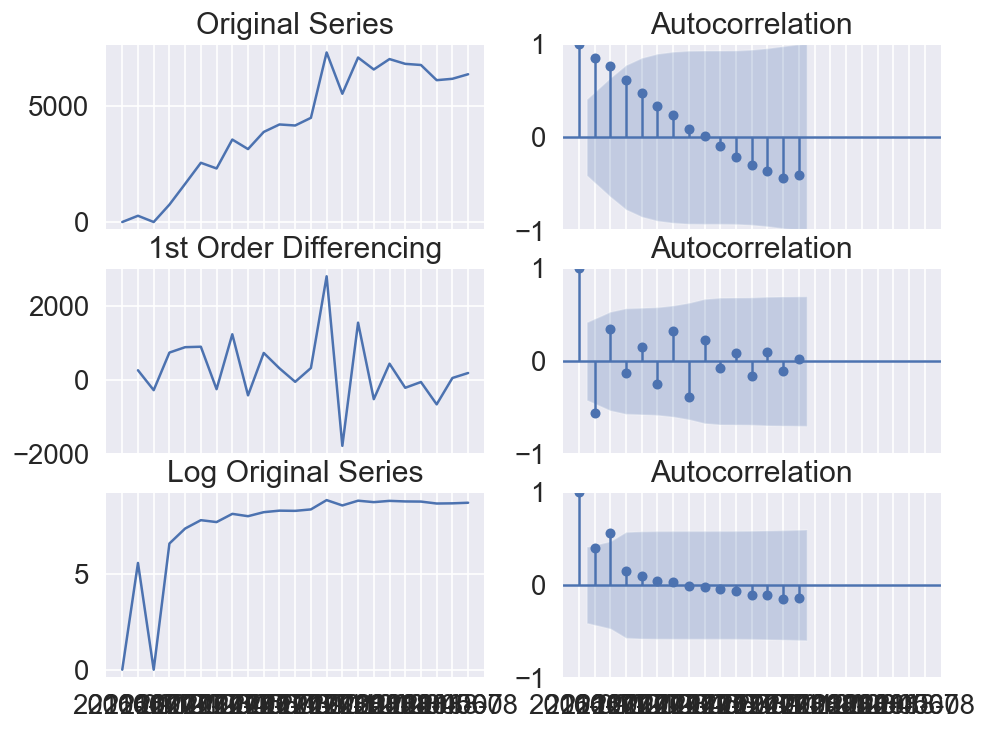

In [44]:
# Look the plots for transformation with Differentiating to make data stationary:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_orders_year_month); axes[0, 0].set_title('Original Series')
plot_acf(df_orders_year_month, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_orders_year_month.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_orders_year_month.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(log_series_order); axes[2, 0].set_title('Log Original Series')
plot_acf(log_series_order, ax=axes[2, 1])


plt.show()

# ARIMA Model for Time Series Forecasting

Let's apply one of the most used methods for forecasting time series, known as ARIMA, which stands Autoregressive Integrated Moving Average.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

In [45]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [46]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_series_order,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:162.30421789871858
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:154.83143546374095
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:63.08199310173224
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:65.08199308328746
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:148.0843460761212
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:150.08434607796318
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:65.08199307523293
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:67.08199304832601
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:143.7125726447618
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:139.74609197635147
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:63.190892633759404
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:65.19089246969595
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:138.50030751673796
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:140.5003075171709
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:65.19089265007321
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:67.19089208793885
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:99.4275173888678
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:101.30542901408202
ARIM

A saída acima sugere que o SARIMAX (1,1,1) x (0, 1, 0, 12) produz o menor valor de AIC de 4.0. Portanto, devemos considerar sso como  melhor opção.


# Adjusting the ARIMA model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -41.736
Date:                Mon, 10 Jan 2022   AIC                             89.473
Time:                        15:10:41   BIC                             92.746
Sample:                             0   HQIC                            90.244
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8675      0.578     -1.500      0.134      -2.001       0.266
ma.L1          0.1803      2.043      0.088      0.930      -3.824       4.184
sigma2         2.4764      0.440      5.630      0.0

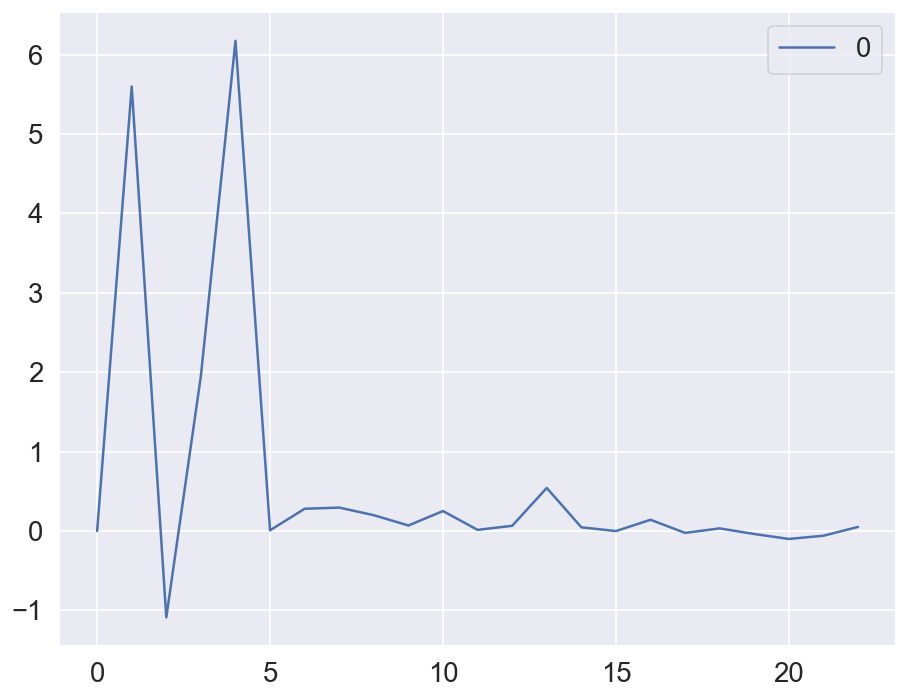

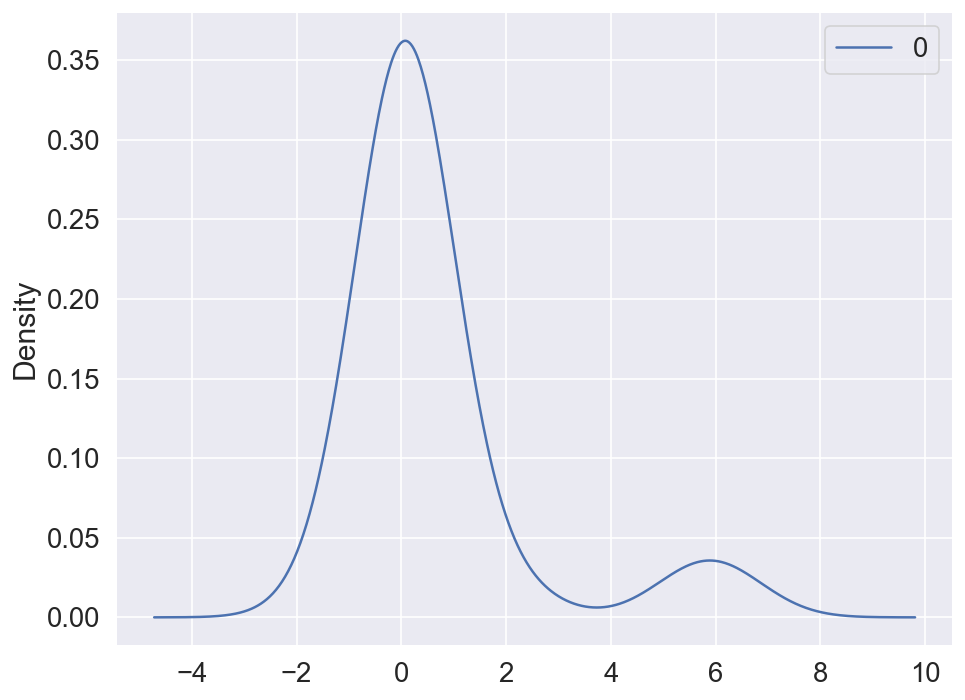

               0
count  23.000000
mean    0.625996
std     1.732893
min    -1.088543
25%    -0.000893
50%     0.050546
75%     0.264866
max     6.174654


In [47]:
from statsmodels.tsa.arima.model import ARIMA

from pandas import DataFrame
# fit model
model = ARIMA(log_series_order, order=(1,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   23
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 -24.052
Date:                             Mon, 10 Jan 2022   AIC                             52.105
Time:                                     15:10:42   BIC                             52.710
Sample:                                          0   HQIC                            51.441
                                              - 23                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4366      0.410     -1.065      0.287      -1.240       0.367
sigma2         7.0388      

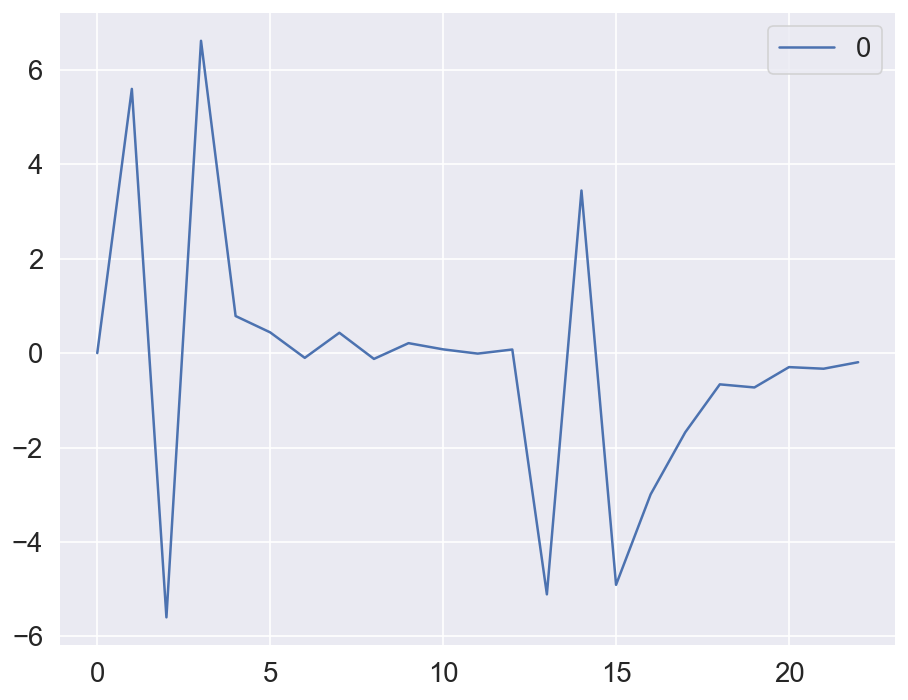

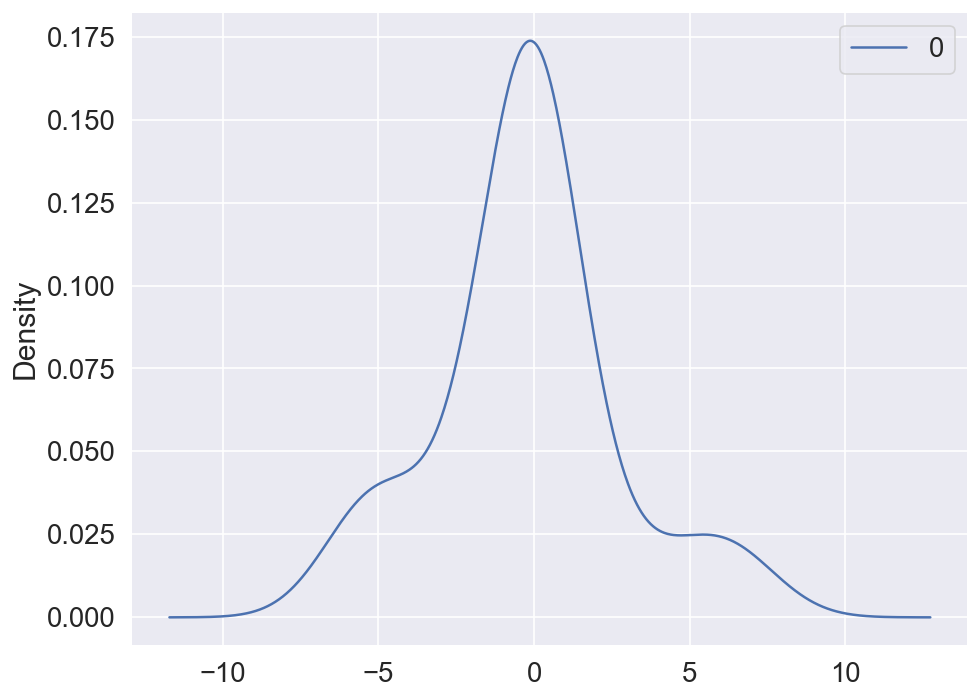

               0
count  23.000000
mean   -0.219505
std     2.872375
min    -5.598405
25%    -0.694708
50%    -0.100310
75%     0.321233
max     6.617386


In [48]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(log_series_order, order=(0,1,1), seasonal_order=(0,1,0,12), enforce_invertibility=False)
resultado_sarimax = model_sarimax.fit()
# summary of fit model
print(resultado_sarimax.summary())
resultado_sarimax.summary()

# line plot of residuals
residuals = DataFrame(resultado_sarimax.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# Predicting sales with ARIMA using Walk Forward

In [49]:
# split into train and test sets
X = log_series_order.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [50]:
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(0,1,0,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=16.253579, expected=8.788136
predicted=9.926620, expected=8.854094
predicted=8.969219, expected=8.824384
predicted=9.186944, expected=8.817150
predicted=8.973980, expected=8.715388
predicted=8.875957, expected=8.725182
predicted=8.939240, expected=8.756368


In [51]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.858


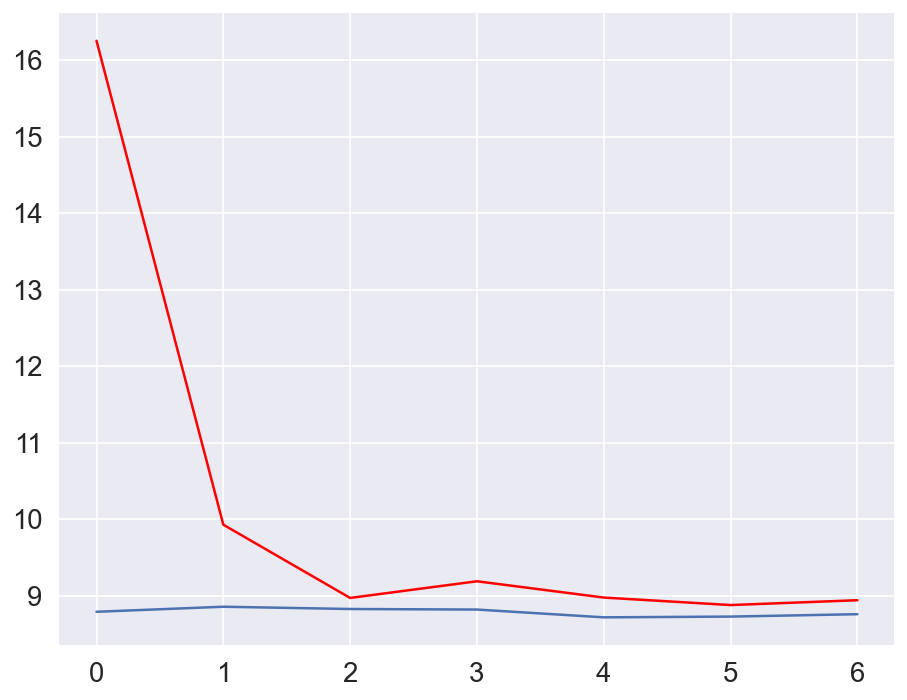

In [52]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# **FORECAST COM PROPHET** Preciso de help aqui

# instanciando o modelo
m = Prophet()
prophet.fit(df_orders_year_month)

# create a future data frame 
future = prophet.make_future_dataframe(periods=25)
forecast = prophet.predict(future)

# **Creating an SARIMAX Model for Time Series Forecasting - Total Sales per year-day**

**STATIONARITY TESTE**

In [53]:
total_sales_daily.set_index('sales_daily',inplace=True)
print(total_sales_daily)

              price
sales_daily        
2016-09-04    72.89
2016-09-05    59.50
2016-09-13     0.00
2016-09-15   134.97
2016-10-02   100.00
...             ...
2018-09-29     0.00
2018-10-01     0.00
2018-10-03     0.00
2018-10-16     0.00
2018-10-17     0.00

[634 rows x 1 columns]


In [54]:
# Test of stationarity.
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

result_sales=adfuller(total_sales_daily.dropna())
print(f'Teste ADF:{result_sales[0]}')
print(f'p-valor:{result_sales[1]}')

Teste ADF:-3.0528622963282235
p-valor:0.03024402316511004


**As p-value is less than 0.05, we reject the null hypothesis that the series is not stationary.**

**Looking for the parameters for the SARIMA model**

In [55]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(total_sales_daily,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14702.947113272443
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:14422.599697374248
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13607.239996261884
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:13428.637519452524
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13832.861605997186
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:13693.66652918161
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:13533.658558601452
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:13423.013319228965
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:14323.870341156286
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14236.902501265453
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13434.428302160577
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:13251.116399652503
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:14176.819861522756
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:14154.09389005807
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:13344.44820362372
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:13250.734441306537
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:13335.082875627693
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:13337.21097135

# **Adjusting the SARIMAX model**

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  634
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6565.012
Date:                            Mon, 10 Jan 2022   AIC                          13140.024
Time:                                    15:11:31   BIC                          13162.181
Sample:                                         0   HQIC                         13148.636
                                            - 634                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3244      0.101      3.219      0.001       0.127       0.522
ma.L1         -0.8158      0.080   

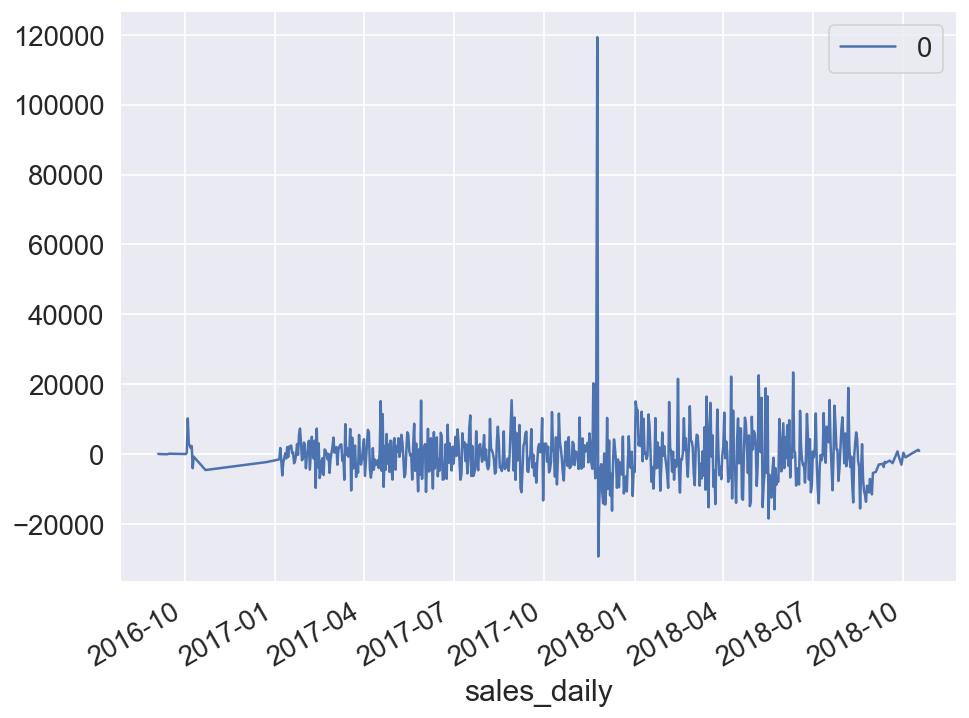

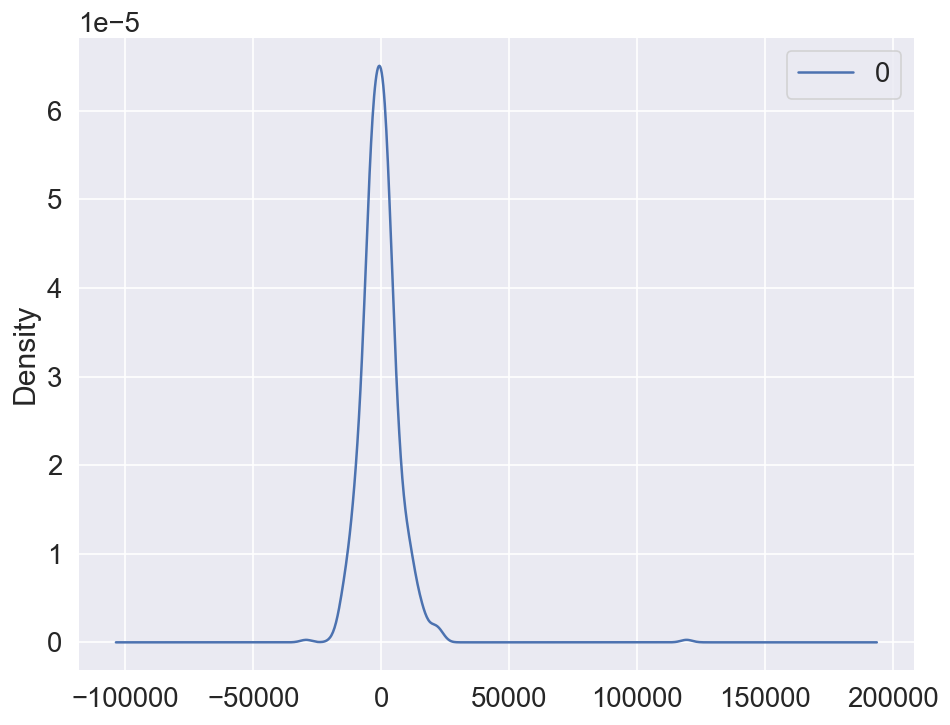

                   0
count     634.000000
mean     -277.491832
std      8190.647467
min    -29319.756563
25%     -4501.158400
50%      -709.900121
75%      2995.332750
max    119321.912704


In [56]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX


model_sarimax = SARIMAX(total_sales_daily, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_invertibility=False)
resultado_sarimax = model_sarimax.fit()
# summary of fit model
print(resultado_sarimax.summary())
resultado_sarimax.summary()

# line plot of residuals
residuals = DataFrame(resultado_sarimax.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

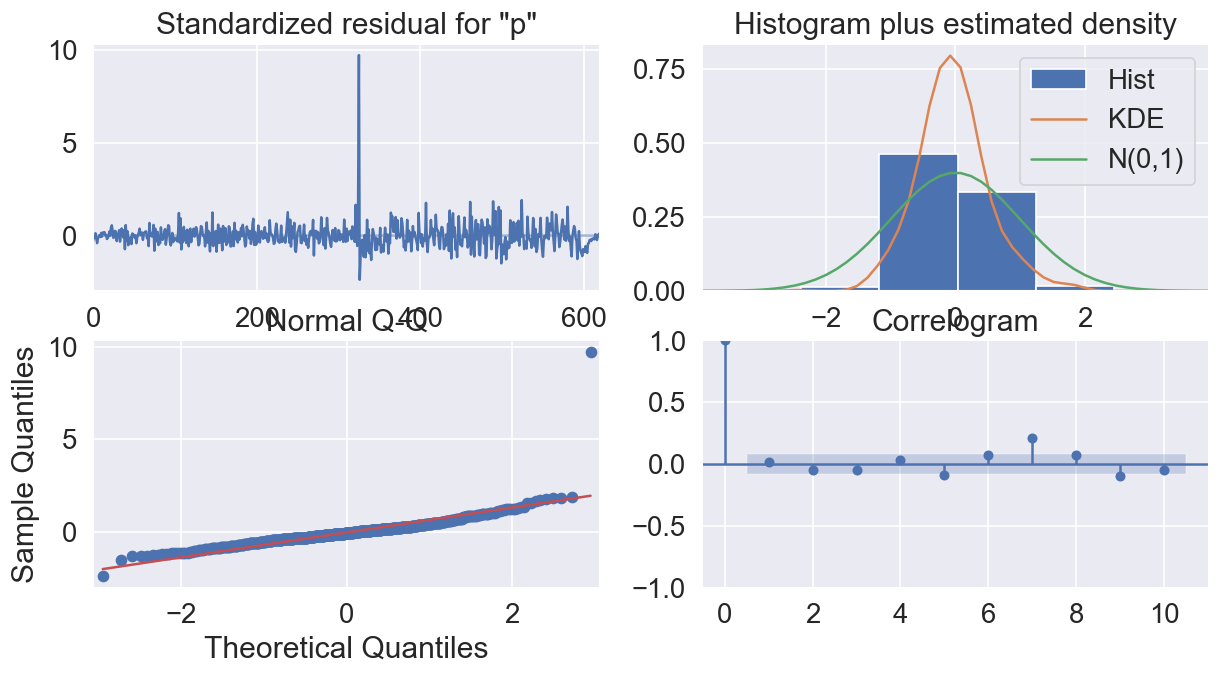

In [88]:
resultado_sarimax.plot_diagnostics(figsize=(12,6))
plt.show()

# **Predicting data with ARIMA using Walk Forward**

In [ ]:
# split into train and test sets
Y = total_sales_daily.values
size = int(len(Y) * 0.7)
train, test = Y[0:size], Y[size:len(Y)]
history = [y for y in train]
predictions = list()

In [156]:
total_sales_daily.values

NameError: name 'total_sales_daily' is not defined

In [ ]:
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(0,1,0,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=32212.444879, expected=29730.420000
predicted=44282.710929, expected=26801.610000
predicted=34300.719212, expected=31605.530000
predicted=42645.025529, expected=31204.090000
predicted=33895.510770, expected=37646.310000
predicted=31857.947033, expected=24373.790000
predicted=23579.684664, expected=46096.400000
predicted=42813.265663, expected=36130.510000
predicted=41821.420190, expected=20378.160000
predicted=31683.856435, expected=33300.600000
predicted=34485.034582, expected=45897.580000
predicted=33716.185080, expected=39364.330000
predicted=34925.624058, expected=42125.890000
predicted=33113.343417, expected=31631.810000
predicted=34358.516004, expected=30053.130000
predicted=30949.734693, expected=23987.160000
predicted=34716.166069, expected=27768.290000
predicted=20172.907691, expected=42112.760000
predicted=54879.215592, expected=38472.290000
predicted=33054.041816, expected=30462.730000
predicted=18206.316460, expected=29581.190000
predicted=38041.018863, expected=2

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 12285.404


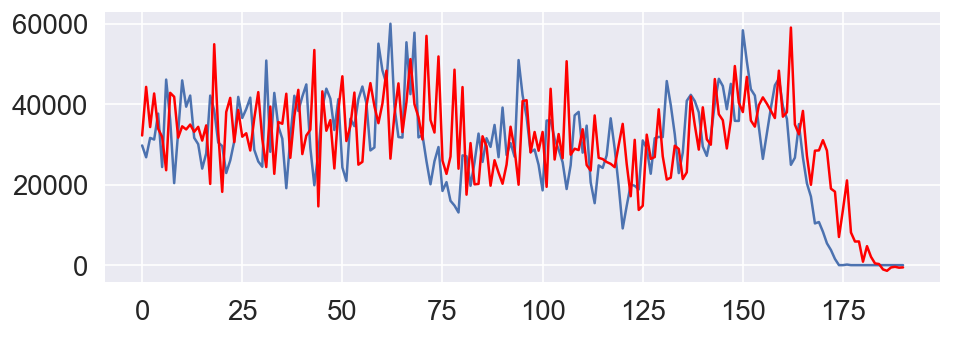

In [ ]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

**References:**

https://github.com/letsdata/series-temporais-python/blob/main/series-temporais-python.ipynb

https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

https://www.linkedin.com/pulse/previs%25C3%25A3o-de-vendas-com-an%25C3%25A1lise-s%25C3%25A9ries-temporais-everton-s-paula/?trackingId=fRvgTUaEQCmaZhLGDBdG7A%3D%3D

https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://github.com/Pedro-Prestes/learning/blob/master/Aula_010_S%C3%A9ries_Temporais_com_Prophet.ipynb